# Planet: Understanding the Amazon from Space 🌳🦌
***By Nhan Phan, November 2019, as an entry to the competition [Planet: Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data) by Kaggle.***

![](https://storage.googleapis.com/kaggle-competitions/kaggle/6322/logos/header.png)

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

This analysis uses Deep Learning to classify the spatial images of the Amazon forest taken by the satilite. And from that, it hopes to shed a light on understanding how the forest has change naturally and manually. Thus, help preventing deforestation.

The dataset is acquired from the Kaggle competition in 2016: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

The dataset contains more than 40.000 images, taken by Planet using sattelites.



> Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

<center><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/6322/media/planet.png" width=300'></center>



### ☆ **RESULT**
The project successfully got the score of 0.90 on the official test set.

|  | THIS PROJECT | WINNER |
|:--:|:--:|:--:|
| **Score (F-Beta)** | 0.90 | 0.93 |

Training information:

|  | Loss | F-Beta Score |
|:--:|:--:|:--:|
| **Train** | 0.09 | 0.90 |
| **Validation** | 0.11 | 0.89 |




### **☆ CHALLENGE**
Several key learnings undercovered through the analysis:

1. **Multi-label:** Each image is labeled with multiple tags (at least 2, at max 9). The tags fall into 17 categories, which are the forest landscape types. Since the tags in each label are mutually exclusive, they are treated as multiple binary classification problems. Thus, `binary cross-entropy` are chosen to be the loss function. 

2. **Imbalance:** The dataset is severely imbalance with tags like Primary or Agriculture appear in 90% of the dataset. While other tags like Blooming or Conventional Mine can only be seen in less than 500 observations (even less than 100 for Burn Down).

  To tackle the problem of imbalance dataset, evaluation metrics has to be chosen carefully. In the first base-line experiment, the model was totally bias toward the major tags. It predicts the major tags to appear in every data and almost never made a prediction with the minor tags. 

  `F2` is chosen to be the main metrics to evaluate the training. It watches over the harmonic mean between the Precision and Recall while favors Recall specifically. In other word, it is the attempt to reduce the number of False Negative, where the model fails to identify the absence of a tag. 

3. **Optimization:** 400.000 images, a CNN model, and Google Colab's limited resource do not seem to mix well together. The training was slow at first and interupted often. Several improvements, mostly on the Tensorflow pipeline, were conducted to speed up the training:

  - Using **TFRecord** to convert the raw images into byte-like data to reduce the amount of time spending on reading data from their paths. 
  - Using [**tf.data.Dataset**](https://www.tensorflow.org/guide/data_performance) with `shuffle`, `map`, `batch`, `prefetch` to optimize the reading data process by redistributing the tasks for agents to work concurrently, thus, avoid bottleneck. An attempt to use `cache` was also made but failed due to the limited RAM. 

4. **Processing image with Tensorflow:** The dataset contains images in JPG - RGBA. The built-in decode function `tf.io.decode_jpeg` only works on 1 or 3-channel image. Attempt on encoding a JPG RGBA image returns black black and black. We need a tensorflow encoding function to work in this part because the pipeline is built entirely on Tensor for the optimization purpose. 

  To tackle the problem, the raw images were first read by Matplotlib then converted into byte-like and wrote into TFRecords. When reading the data from TF Record, instead of using the built-in decode image function, we use `tf.io.parse_tensor` following with reshaping.




## 1. PREPROCESS DATA



### 1.1 Import Libraries

In [43]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 13.1 MB/s 


In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
tf.random.set_seed(142)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [44]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow_addons as tfa
from tensorflow_addons.metrics import FBetaScore 

import tqdm.notebook as tq
import os
import logging
import warnings
warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### 1.2 Explore Dataset

In [7]:
# # Dataset folders are manually downloaded from Kaggle as .tar.7z file
# # Install 7zip if not in the environment yet 
# ! sudo apt-get install p7zip-full

# # Unzip dataset
# ! 7z x -so /content/gdrive/MyDrive/PROJECT/AMAZON/data/train-jpg.tar.7z | tar xf - -C /content/gdrive/MyDrive/PROJECT/AMAZON/data

In [6]:
PROJECT_FOLDER = '/content/gdrive/MyDrive/PROJECT/AMAZON'
DATA_PATH = os.path.join(PROJECT_FOLDER, "data")
TRAIN_JPG_DIR = os.path.join(DATA_PATH, "train-jpg")
TRAIN_CSV_PATH = os.path.join(DATA_PATH, "train_v2.csv")

In [8]:
df = pd.read_csv(TRAIN_CSV_PATH)
df.head(5)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


One-hot encode the labels.

In [9]:
dummies = df['tags'].str.get_dummies(' ')
df = pd.concat([df, dummies], axis=1)

labels = dummies.columns.values
N_LABELS = len(labels)
dummies

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40474,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40475,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40476,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40477,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0


In [10]:
print(f"There are {N_LABELS} unique labels including {labels}")

There are 17 unique labels including ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


Read more about the definition of each label [HERE](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data) 

In [11]:
# Countplot of label distribution
label_count = dummies.sum(axis=0).sort_values()
print(label_count)

blow_down               98
conventional_mine      100
slash_burn             209
blooming               332
artisinal_mine         339
selective_logging      340
bare_ground            862
cloudy                2089
haze                  2697
habitation            3660
cultivation           4477
partly_cloudy         7261
water                 7411
road                  8071
agriculture          12315
clear                28431
primary              37513
dtype: int64


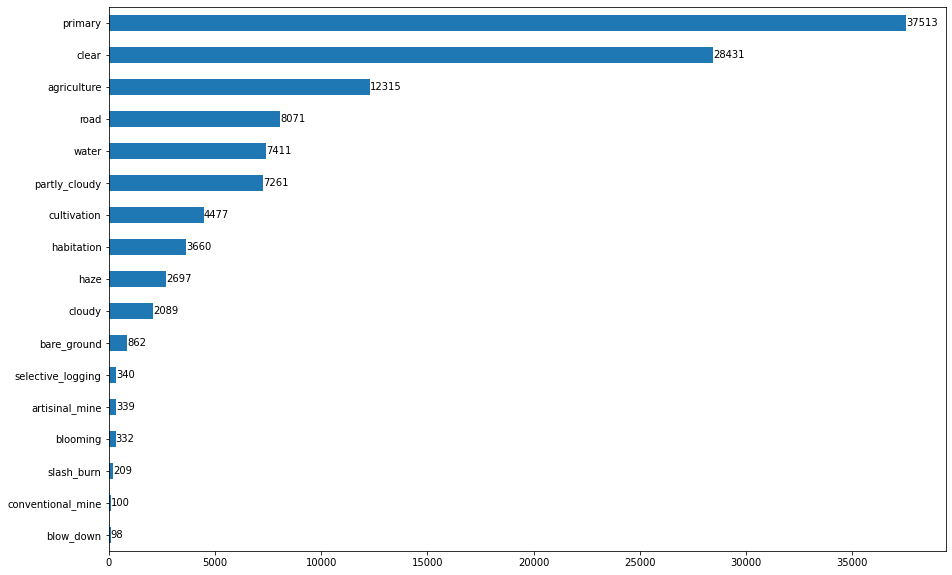

In [12]:
label_count.plot(kind='barh', figsize=(15, 10))
for i in range(label_count.shape[0]):
    plt.text(label_count.iloc[i] + 4, i, label_count.iloc[i], va='center')

As we can see, the dataset's labels are not evenly distributed. The `primary` and `clear` tags appear in more than 80% of the dataset while some others, for examples, `blooming`, `slash burn` or `blow_down` are rarely observed.

Let's take a closer look as what these labels visually depict.

In [13]:
images_title = [df[df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' for i, label in enumerate(labels)]

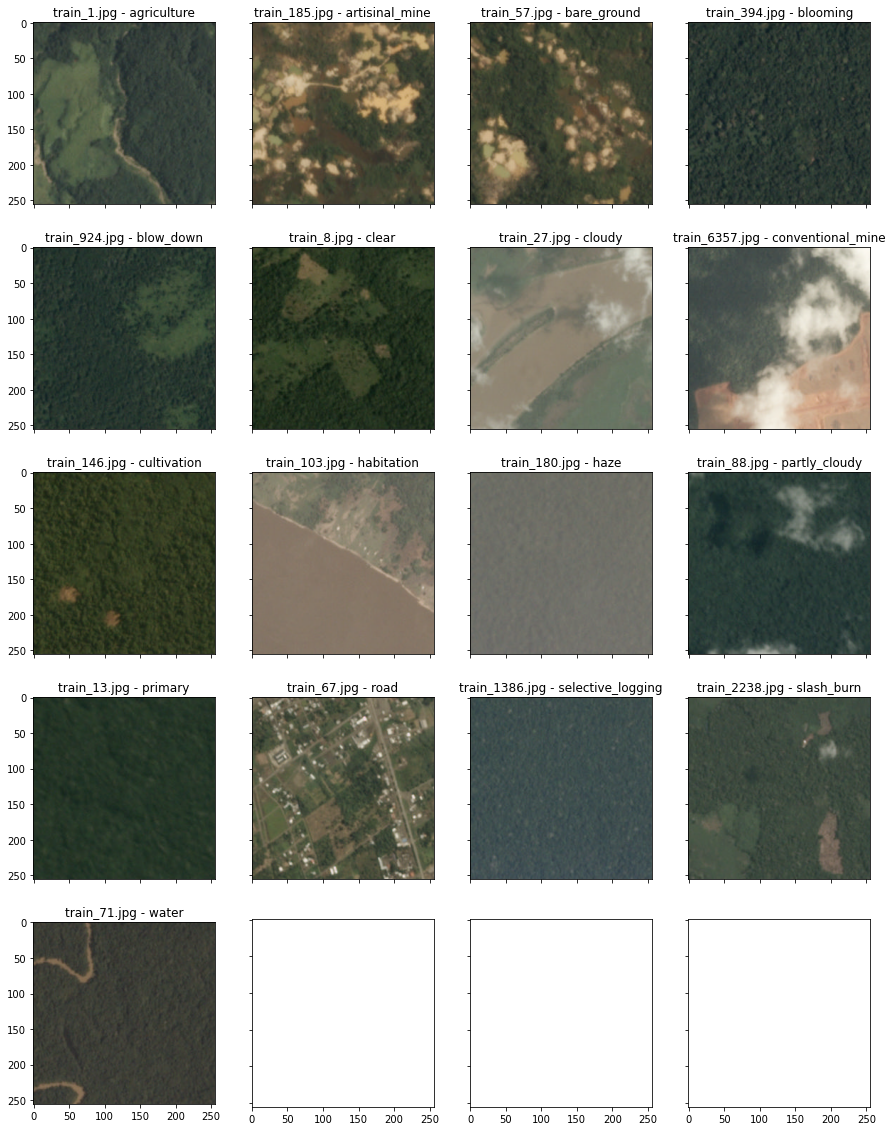

In [14]:
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels)):
    img_path = os.path.join(TRAIN_JPG_DIR, image_name)
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(f'{image_name} - {label}')

### 1.4. Split dataset

- The datatset is divided into 80% train and 20% validation. We also split the train into 4 folds, which later will be store in 4 TFRecords shards. 
- `MultilabelStratifiedKFold` is used to maintain the ratio of label across each shard. 

In [15]:
!pip install iterative_stratification -q
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [16]:
y = df[labels].values
X = df['image_name'].values

df['fold'] = np.nan

mskf = MultilabelStratifiedKFold(n_splits=5, random_state=104)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    df.iloc[test_index, -1] = i
   
df['fold'] = df['fold'].astype('int')
df['is_valid'] = False
df['is_valid'][df['fold'] == 0] = True

In [26]:
# Number of observations of each tags in each fold. 
df.groupby('fold')[labels].sum()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
fold,,,,,,,,,,,,,,,,,
0,2463,68,173,67,19,5706,418,20,895,732,539,1452,7502,1614,68,42,1482
1,2463,68,172,67,20,5702,418,20,895,732,539,1452,7502,1614,68,41,1482
2,2463,68,172,66,20,5665,418,20,895,732,540,1452,7503,1614,68,42,1482
3,2463,68,173,66,20,5682,418,20,896,732,539,1452,7503,1614,68,42,1482
4,2463,67,172,66,19,5676,417,20,896,732,540,1453,7503,1615,68,42,1483


In [40]:
TRAIN_SIZE = df.shape[0] - df['is_valid'].sum()
VAL_SIZE = df['is_valid'].sum()

### 1.4. Export raw data to TFRecords

In [29]:
# Converting the values into features

def _image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def _int64_feature(value):
    if type(value) != list:
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array


def image_feature(path, label):
    image = plt.imread(path)

    # image = tf.io.decode_jpeg(image, channels=3)
    feature = {'height': _int64_feature(image.shape[0]),
               'width': _int64_feature(image.shape[1]),
               'channel': _int64_feature(image.shape[2]),
               'image': _bytes_feature(serialize_array(image)),
               'label': _int64_feature(label),}
    return tf.train.Example(features=tf.train.Features(feature=feature))


def create_record(df, folder_path, record_name):
    all_image_paths = df['image_name'].apply(lambda x: os.path.join(TRAIN_JPG_DIR, x+'.jpg')).values
    all_labels = df[labels].values

    record_path = os.path.join(folder_path, f"{record_name}.tfrecords")
    writer = tf.io.TFRecordWriter(record_path) 

    for i in tq.tqdm(range(df.shape[0])):
        path = all_image_paths[i]
        label = all_labels[i].tolist()
        example = image_feature(path, label)
        writer.write(example.SerializeToString())
    
    writer.close()

In [26]:
# for i in range(5): 
#     create_record(df[df['fold'] == i], DATA_PATH, f'fold_{i}')

### 1.5 Load data from TFRecord

In [30]:
RECORDS = tf.io.gfile.glob(str(DATA_PATH + '/*.tfrecords'))
RECORDS

['/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_0.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_1.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_2.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_3.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_4.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/1_val_sample.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/1_train_sample.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/test.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/test-additional.tfrecords']

In [31]:
IMG_WIDTH, IMG_HEIGHT = 192, 192
CHANNELS = 3

def read_tfrecord(example):
    tfrecord_format = {
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "channel": tf.io.FixedLenFeature([], tf.int64),
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([17], tf.int64, default_value=np.zeros((17,)).astype('int').tolist())
    }
    example = tf.io.parse_single_example(example, tfrecord_format)

    # Extract information
    height = example['height']
    width = example['width']
    channel = example['channel']
    image = example['image']
    label = example['label']

    # Convert raw image back to array
    image = tf.io.parse_tensor(image, out_type=tf.uint8)
    image = tf.reshape(image, shape=[height, width, channel])
    if channel == 4:
        image = image[:,:,:3]

    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])

    return (image, label)

In [32]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1024
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [33]:
def augmentation(image, label):
    image = tf.image.random_brightness(image, .1)
    image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

def load_dataset(filenames, shuffle=False, augment=False):
    """Load a list of pahts of TFRecords 
       and split them into train and validation set."""

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)

    # dataset = dataset.cache()

    if shuffle == True:
        dataset = dataset.shuffle(buffer_size = SHUFFLE_BUFFER_SIZE).repeat()

    if augment == True:
        dataset.map(augmentation, num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [34]:
RECORDS

['/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_0.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_1.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_2.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_3.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_4.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/1_val_sample.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/1_train_sample.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/test.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/test-additional.tfrecords']

In [35]:
train_ds = load_dataset(RECORDS[:4], shuffle=True, augment=True)
val_ds = load_dataset(RECORDS[4], shuffle=False, augment=False)

In [36]:
train_ds

<PrefetchDataset shapes: ((None, 192, 192, None), (None, 17)), types: (tf.float32, tf.int64)>

In [37]:
val_ds

<PrefetchDataset shapes: ((None, 192, 192, None), (None, 17)), types: (tf.float32, tf.int64)>

Now, our data is ready to flow into the model.

Each batch will be a pair of arrays (one that holds the features and another that hold labels). 
- The features array will be of shape (BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, CHANNELS).
- The labels array will be of shape (BATCH_SIZE, N_LABELS).

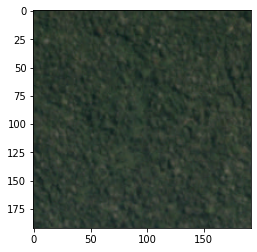

In [42]:
for i in train_ds.take(1):
    plt.imshow(i[0][1].numpy() / 255.)
    plt.show()

### ❊ Read sample

For acquiring a small sample of dataset (20%) and split to train-validation (80/20) 

In [40]:
# sample = df[df['fold'] == 0]
# sample.head()

In [41]:
# sample[labels].sum() / df[labels].sum()

In [42]:
# X_sample = sample['image_name'].apply(lambda x: os.path.join(DATA_PATH, 'train-jpg', x+".jpg")).values
# y_sample = sample[labels].values 

In [43]:
# sample.drop(columns=['fold', 'is_valid'], inplace=True)

In [44]:
# sample['fold'] = np.nan

# mskf = MultilabelStratifiedKFold(n_splits=5, random_state=104)
# for i, (_, test_index) in enumerate(mskf.split(X_sample, y_sample)):
#     sample.iloc[test_index, -1] = i
   
# sample['fold'] = sample['fold'].astype('int')
# sample['is_valid'] = False
# sample['is_valid'][sample['fold'] == 0] = True

In [45]:
# sample.groupby('is_valid')[labels].sum()

In [46]:
# create_record(sample[sample['is_valid'] == False], DATA_PATH, '1_train_sample')

In [47]:
# create_record(sample[sample['is_valid'] == True], DATA_PATH, '1_val_sample')

In [48]:
# sample['is_valid'].sum()

In [49]:
# TRAIN_SIZE = sample.shape[0] - sample['is_valid'].sum()
# VAL_SIZE = sample['is_valid'].sum()

In [50]:
# train_ds = load_dataset(RECORDS[-2], shuffle=True, augment=True)
# val_ds = load_dataset(RECORDS[-1])

In [51]:
# for i in train_ds.take(1):
#     plt.imshow(i[0][1].numpy() / 255.)
#     plt.show()

## 2. MODELLING

### 2.1. Build model

Instead of building and training a new model from scratch, we will use a pre-trained model in a process called transfer learning. In this case, we use the MobileNetv2 model.

![alt text](https://miro.medium.com/max/1400/1*yT0lWepQ39hrwn5KBaMz_A.png)

In [45]:
def build_model(trainable = False, fine_tune_at = 0):
    """Build a Sequential model with the MobileNetv2 as base model and additional top layers.
       Certain number of layers of the MobileNetv2 can be trained.
       args:
           trainable: boolean, whether transfer learning model can be trained or not.
           fine_tune_at: int, number of trainable layers.
    
    """
    mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS), include_top=False)
    if trainable == True:
        mobile_net.trainable=True

        for layer in mobile_net.layers[:fine_tune_at]:
            layer.trainable = False
    else: 
        mobile_net.trainable = False
    

    input = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS), name='input')
    x = tf.keras.applications.mobilenet.preprocess_input(input)
    x = mobile_net(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(N_LABELS, activation = 'sigmoid')(x)

    model = tf.keras.Model(input, output)
    return model

In [46]:
model = build_model()
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 192, 192, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 192, 192, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
dense (Dense)                (None, 6, 6, 1024)        1311744   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
________________________________________________________________

Take a look at prediction. The model will return a list of 17 values according to 17 labels. Each value represents the probability that the observation includes that label. 

In [47]:
for batch in train_ds: 
    print(model.predict(batch[0]))
    break

[[0.3261649  0.45559844 0.20978181 ... 0.47731888 0.30492356 0.29225415]
 [0.3743346  0.47967747 0.25087893 ... 0.43465114 0.3260643  0.3062575 ]
 [0.4605533  0.5086682  0.2516514  ... 0.54276913 0.35577878 0.32366514]
 ...
 [0.54772836 0.49749044 0.29130355 ... 0.42879832 0.3875842  0.36455578]
 [0.56962293 0.5005135  0.25453034 ... 0.53939515 0.38510564 0.3693343 ]
 [0.39316067 0.8009843  0.22984095 ... 0.5477519  0.21274917 0.35347572]]


### 2.2. Train

Using **Checkpoint**, **LearningRateDecay**, and **CSVLogger** to assist the training. 

In [ ]:
from datetime import datetime
today = str(datetime.now().date())
try:
    os.mkdir(os.path.join(PROJECT_FOLDER, 'log', today))
except:
    print('Folder exists.')

In [62]:
# Setting up CheckPoint 
checkpoint_path = os.path.join(PROJECT_FOLDER, 'log', today, f"full_1_decay.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights by default it saves the weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 save_weights_only=True,
                                                 mornitor = "val_loss",
                                                 verbose=1)

# Learning rate decay
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                factor=0.2, 
                                                patience=3, 
                                                verbose=1, 
                                                mode='auto', 
                                                epsilon=0.0001, 
                                                cooldown=0, 
                                                min_lr=0.0000001)

# Logger
log_path = os.path.join(PROJECT_FOLDER, 'log', today, f"full_1_decay.csv")
logger = tf.keras.callbacks.CSVLogger(log_path, separator=',', append=True)

In [49]:
LR = 1e-5
EPOCHS = 60
num_steps_train = tf.math.ceil(float(TRAIN_SIZE)/BATCH_SIZE)              
num_steps_val = tf.math.ceil(float(VAL_SIZE)/BATCH_SIZE)

fbeta = FBetaScore(num_classes=N_LABELS,
                   average='weighted',
                   beta=2.0,
                   threshold=0.2,
                   name='fbeta')

In [ ]:
# Compile model with optimizer
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
               loss = 'binary_crossentropy',
               metrics = [fbeta, tf.keras.metrics.AUC()])

In [63]:
# model.load_weights(checkpoint_path)

In [64]:
# Train model
history = model.fit(train_ds,
                  steps_per_epoch = num_steps_train,
                  epochs = EPOCHS,
                  validation_data = val_ds,
                  validation_steps = num_steps_val,
                  callbacks=[cp_callback, lr_decay, logger])

Epoch 1/60
507/507 [==============================] - 290s 506ms/step - loss: 0.2481 - fbeta: 0.7918 - auc: 0.9258 - val_loss: 0.1684 - val_fbeta: 0.8391 - val_auc: 0.9638

Epoch 00001: val_loss improved from inf to 0.16841, saving model to /content/gdrive/MyDrive/PROJECT/AMAZON/log/2021-08-23/full_1_decay.h5
Epoch 2/60
507/507 [==============================] - 280s 553ms/step - loss: 0.1538 - fbeta: 0.8491 - auc: 0.9692 - val_loss: 0.1453 - val_fbeta: 0.8566 - val_auc: 0.9721

Epoch 00002: val_loss improved from 0.16841 to 0.14529, saving model to /content/gdrive/MyDrive/PROJECT/AMAZON/log/2021-08-23/full_1_decay.h5
Epoch 3/60
507/507 [==============================] - 276s 545ms/step - loss: 0.1395 - fbeta: 0.8614 - auc: 0.9743 - val_loss: 0.1369 - val_fbeta: 0.8631 - val_auc: 0.9751

Epoch 00003: val_loss improved from 0.14529 to 0.13691, saving model to /content/gdrive/MyDrive/PROJECT/AMAZON/log/2021-08-23/full_1_decay.h5
Epoch 4/60
507/507 [==============================] - 283s 

In [65]:
 def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

<Figure size 1080x720 with 0 Axes>

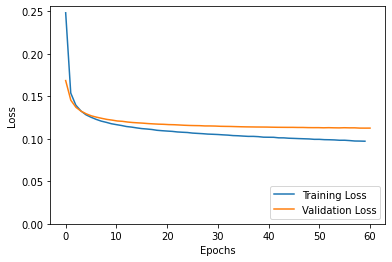

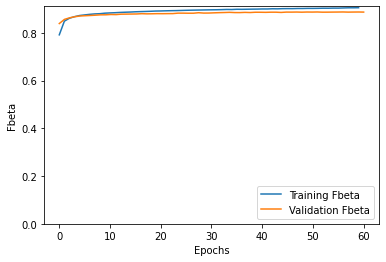

In [66]:
plt.figure(figsize = (15, 10))

plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['fbeta'], history.history['val_fbeta'], x_label='Epochs', stats='fbeta');

### 2.3 Export model

In [53]:
SAVE_PATH = os.path.join(PROJECT_FOLDER, 'log', today, '1_full_decay.h5')
model.save(SAVE_PATH)

### 2.4 Predict

In [48]:
SAVE_PATH = '/content/gdrive/MyDrive/PROJECT/AMAZON/data/log/2021-08-23/1_full_decay.h5'
model = tf.keras.models.load_model(SAVE_PATH)

In [50]:
def read_tfrecord_label_only(example):
    tfrecord_format = {
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "channel": tf.io.FixedLenFeature([], tf.int64),
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([17], tf.int64, default_value=np.zeros((17,)).astype('int').tolist())
    }
    example = tf.io.parse_single_example(example, tfrecord_format)

    # Extract information
    height = example['height']
    width = example['width']
    channel = example['channel']
    image = example['image']
    label = example['label']

    return label

In [79]:
train_label_ds = tf.data.TFRecordDataset(RECORDS[:4])
train_label_ds = train_label_ds.map(read_tfrecord_label_only, num_parallel_calls=AUTOTUNE)

In [81]:
true = list(train_label_ds.as_numpy_iterator())
true = np.array(true)
true.shape

(32358, 17)

In [82]:
train_image_ds = load_dataset(RECORDS[:4], shuffle=False, augment=False)

In [83]:
predictions = model.predict(train_image_ds)
final_predictions = (predictions > 0.2).astype('int')
final_predictions.shape

(32358, 17)

In [120]:
from sklearn.metrics import fbeta_score
fbeta_score(true, final_predictions, average='weighted', beta=2)

0.9052314129210649

In [84]:
from sklearn.metrics import classification_report
print(classification_report(true, final_predictions))

              precision    recall  f1-score   support

           0       0.71      0.93      0.80      9852
           1       0.75      0.79      0.77       271
           2       0.48      0.42      0.45       689
           3       0.31      0.10      0.15       266
           4       0.82      0.12      0.20        78
           5       0.89      0.99      0.94     22719
           6       0.72      0.94      0.81      1671
           7       0.73      0.64      0.68        80
           8       0.46      0.73      0.56      3582
           9       0.56      0.81      0.66      2928
          10       0.58      0.83      0.68      2158
          11       0.77      0.90      0.83      5809
          12       0.96      1.00      0.98     30011
          13       0.70      0.91      0.79      6457
          14       0.40      0.23      0.29       272
          15       0.37      0.10      0.15       168
          16       0.66      0.86      0.75      5929

   micro avg       0.80   

In [98]:
for data in train_image_ds.take(1):
    sample_images = data[0].numpy().astype('int')
    sample_labels = data[1].numpy().astype('bool')

sample_images = sample_images[:40]
sample_labels = sample_labels[:40]
sample_predictions = final_predictions[:40]

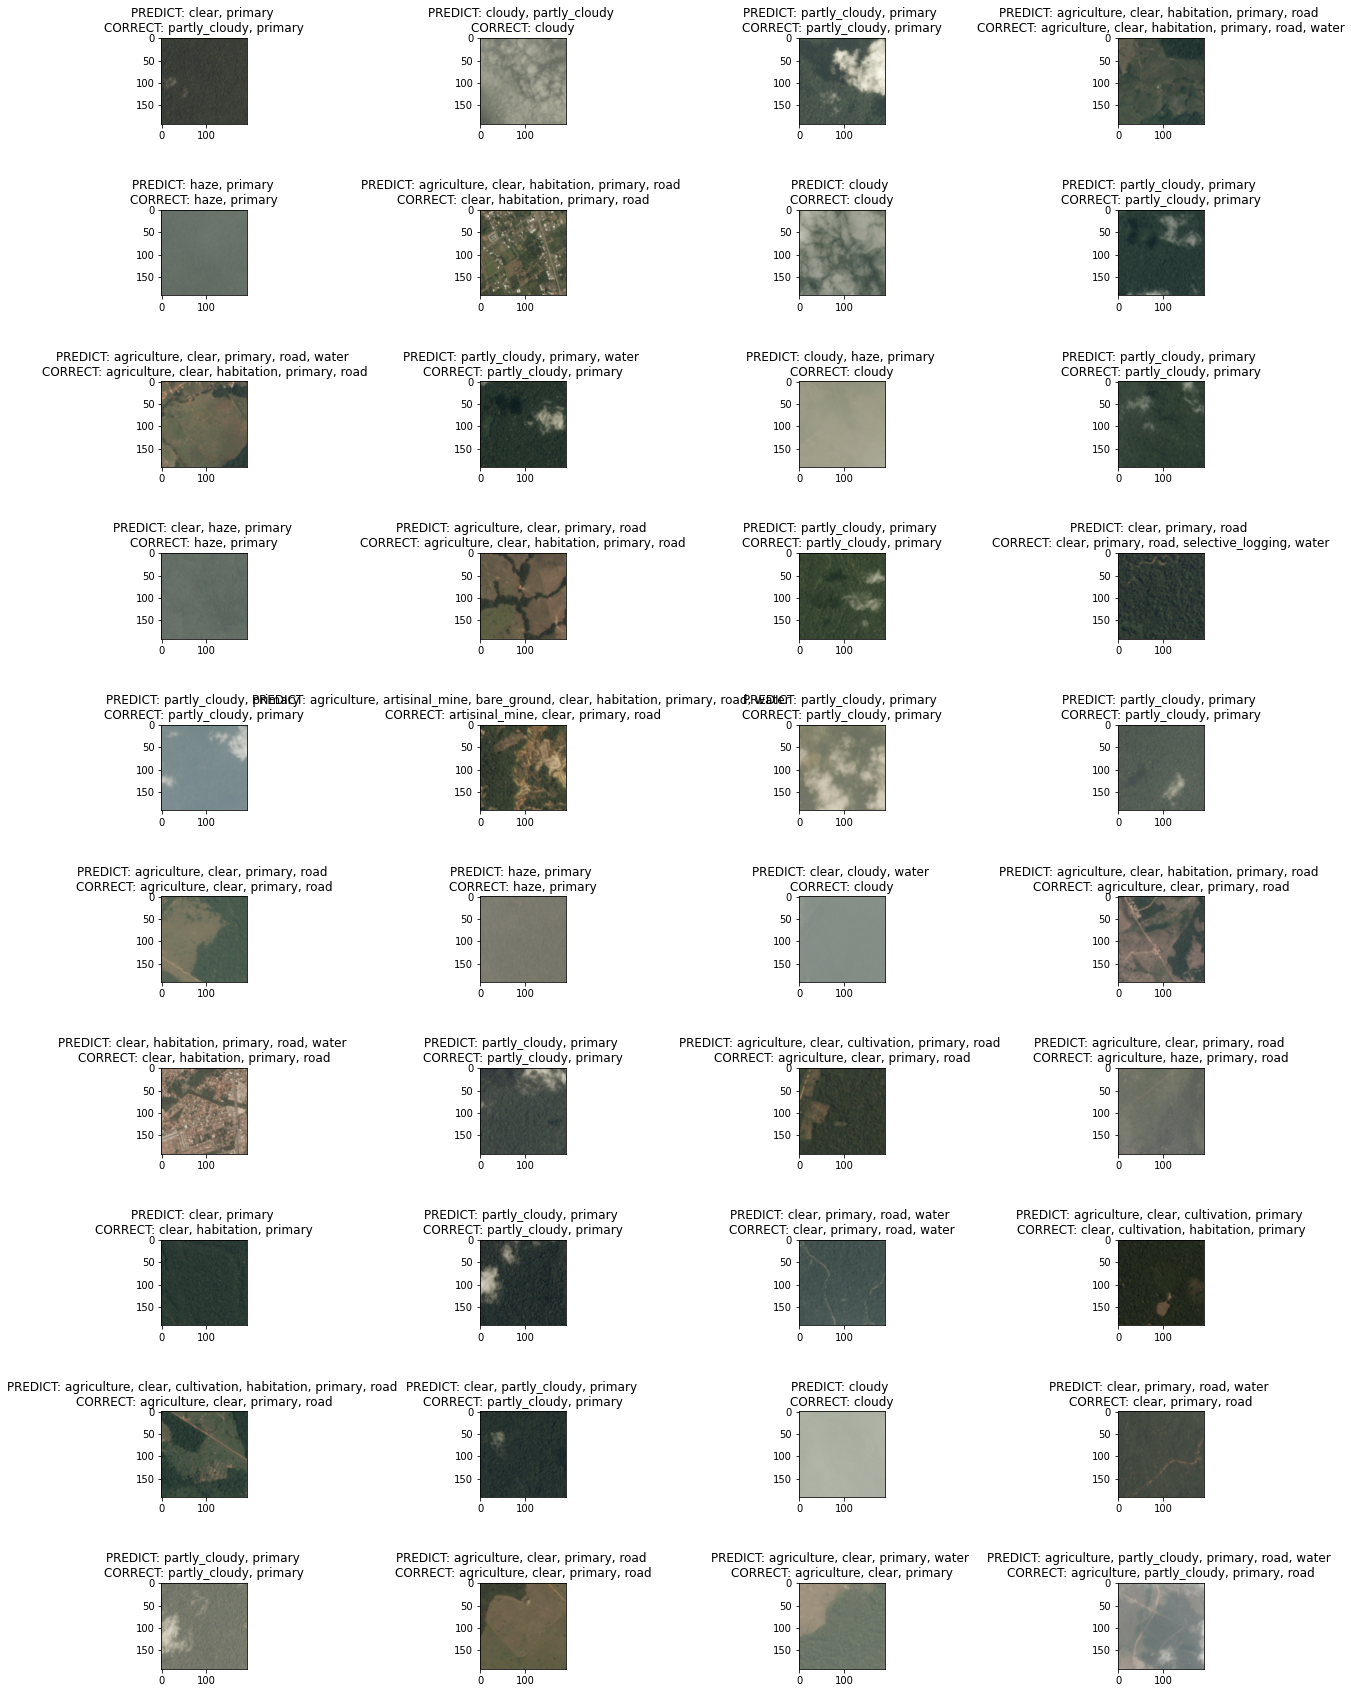

In [105]:
fig, axes = plt.subplots(10, 4, figsize=(20, 30))
axes = axes.ravel()

for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    axes[i].imshow(image)
    predict_label = labels[sample_predictions[i] == 1]
    predict_label = ', '.join(predict_label)
    correct = ', '.join(labels[label])
    axes[i].set_title(f"PREDICT: {predict_label} \nCORRECT: {correct}")

plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

## 3. TUNING THRESHOLD

Since the multi-label problem is viewed as multiple binary classification tasks, it is necessary to define an appropriate threshold. Any predicted probability above the threshold yield a positive prediction for that tag. The value of the threshold affects the F score greatly, especially in the context of an imbalance dataset, where each label has different frequency.

In the experiment of tuning threshold, we increase the threshold from 0 to 1 by a step of 0.01 for each label and observe the change of Precision, Recall, F1 and FBeta Score.

In [122]:
def perf_grid(y_hat_val, y_val, label_names, n_thresh=100):
    
    # Find label frequencies in the validation set
    label_freq = y_val.sum(axis=0)

    # Define thresholds
    thresholds = np.linspace(0, 1, n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s, f2s = [], [], [], [], [], [], [], [], [], []
    
    for i in tq.tqdm(range(len(label_names))):
        for thresh in thresholds:   
            ids.append(i)
            labels.append(label_names[i])
            freqs.append(round(label_freq[i]/len(y_val),2))

            y = y_val[:, i]
            y_pred = y_hat_val[:, i] > thresh

            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            f2 = fbeta_score(y, y_pred, average='weighted', beta=2)
            
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            f2s.append(f2)
            
    # Create the performance dataframe
    grid = pd.DataFrame({'id':ids,
                         'label':labels,
                         'freq':freqs,
                         'threshold':list(thresholds)*len(label_names),
                         'tp':tps,
                         'fp':fps,
                         'fn':fns,
                         'precision':precisions,
                         'recall':recalls,
                         'f1':f1s,
                         'f2': f2s})
    
    return grid

In [86]:
predictions.shape

(32358, 17)

In [87]:
true.shape

(32358, 17)

In [123]:
# Performance table
grid = perf_grid(predictions, true, labels)

  0%|          | 0/17 [00:00<?, ?it/s]

In [124]:
grid[grid['label'].str.contains('primary')].head(20)

,id,label,freq,threshold,tp,fp,fn,precision,recall,f1,f2
1212,12,primary,0.93,0.00,30011,2347,0,0.927468,1.000000,0.962369,0.913185
1213,12,primary,0.93,0.01,30011,2248,0,0.930314,1.000000,0.963899,0.917563
1214,12,primary,0.93,0.02,30011,2116,0,0.934136,1.000000,0.965947,0.923280
1215,12,primary,0.93,0.03,30009,1973,2,0.938309,0.999933,0.968142,0.929274
1216,12,primary,0.93,0.04,30009,1869,2,0.941370,0.999933,0.969768,0.933576
1217,12,primary,0.93,0.05,30007,1794,4,0.943587,0.999867,0.970912,0.936578
1218,12,primary,0.93,0.06,30001,1723,10,0.945688,0.999667,0.971928,0.939274
1219,12,primary,0.93,0.07,29999,1642,12,0.948105,0.999600,0.973172,0.942436
1220,12,primary,0.93,0.08,29996,1559,15,0.950594,0.999500,0.974434,0.945605
1221,12,primary,0.93,0.09,29989,1479,22,0.953000,0.999267,0.975585,0.948503


In [125]:
# Choose the best threshold of 
grid_max = grid.loc[grid.groupby(['id', 'label'])[['f2']].idxmax()['f2'].values]
grid_max

,id,label,freq,threshold,tp,fp,fn,precision,recall,f1,f2
44,0,agriculture,0.30,0.44,8103,1601,1749,0.835016,0.822473,0.828697,0.896377
142,1,artisinal_mine,0.01,0.41,189,22,82,0.895735,0.697417,0.784232,0.996686
233,2,bare_ground,0.02,0.31,194,108,495,0.642384,0.281567,0.391524,0.979745
331,3,blooming,0.01,0.28,18,15,248,0.545455,0.067669,0.120401,0.990553
423,4,blow_down,0.00,0.19,9,2,69,0.818182,0.115385,0.202247,0.997450
560,5,clear,0.70,0.55,21967,1393,752,0.940368,0.966900,0.953450,0.933336
659,6,cloudy,0.05,0.53,1375,215,296,0.864780,0.822861,0.843300,0.984127
740,7,conventional_mine,0.00,0.33,49,9,31,0.844828,0.612500,0.710145,0.998716
846,8,cultivation,0.11,0.38,1710,913,1872,0.651925,0.477387,0.551168,0.911220
952,9,habitation,0.09,0.43,1774,467,1154,0.791611,0.605874,0.686400,0.948444


## 4. PREDICT ON TEST 

In [228]:
# # # Dataset folders are manually downloaded from Kaggle as .tar.7z file
# # # Install 7zip if not in the environment yet 
# ! sudo apt-get install p7zip-full

# # # Unzip dataset
# ! 7z x -so /content/gdrive/MyDrive/PROJECT/AMAZON/data/test-jpg-additional.tar.7z | tar xf - -C /content/gdrive/MyDrive/PROJECT/AMAZON/data

In [119]:
test_paths = tf.io.gfile.glob(str(DATA_PATH + '/test-jpg/*.jpg')) 
additional_paths = tf.io.gfile.glob(str(DATA_PATH + '/test-jpg-additional/*.jpg')) 

In [232]:
def create_test_record(data_folder, record_name):
    paths = tf.io.gfile.glob(str(data_folder + f'/{record_name}/*.jpg')) 

    record_path = os.path.join(data_folder, f"{record_name}.tfrecords")
    writer = tf.io.TFRecordWriter(record_path) 

    for i in tq.tqdm(range(len(paths))):
        path = paths[i]
        image = plt.imread(path)
        feature = {'height': _int64_feature(image.shape[0]),
                   'width': _int64_feature(image.shape[1]),
                   'channel': _int64_feature(image.shape[2]),
                   'image': _bytes_feature(serialize_array(image))}
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())
    writer.close()

In [233]:
create_test_record(DATA_PATH, 'test-jpg')
create_test_record(DATA_PATH, 'test-jpg-additional')

  0%|          | 0/20522 [00:00<?, ?it/s]

In [130]:
def read_test_record(example): 
    tfrecord_format = {
            "height": tf.io.FixedLenFeature([], tf.int64),
            "width": tf.io.FixedLenFeature([], tf.int64),
            "channel": tf.io.FixedLenFeature([], tf.int64),
            "image": tf.io.FixedLenFeature([], tf.string)
            }

    example = tf.io.parse_single_example(example, tfrecord_format)

    # Extract information
    height = example['height']
    width = example['width']
    channel = example['channel']
    image = example['image']

    # Convert raw image back to array
    image = tf.io.parse_tensor(image, out_type=tf.uint8)
    image = tf.reshape(image, shape=[height, width, channel])
    if channel == 4:
        image = image[:,:,:3]

    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    return image

In [131]:
def load_test_dataset(filenames, shuffle=False, augment=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_test_record, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [132]:
RECORDS = tf.io.gfile.glob(str(DATA_PATH + '/*.tfrecords'))
RECORDS

['/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_0.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_1.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_2.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_3.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/fold_4.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/1_val_sample.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/1_train_sample.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/test.tfrecords',
 '/content/gdrive/MyDrive/PROJECT/AMAZON/data/test-additional.tfrecords']

In [146]:
test_ds = load_test_dataset(RECORDS[-2])
additional_ds = load_test_dataset(RECORDS[-1])

In [147]:
test_predictions = model.predict(test_ds)
additional_predictions = model.predict(additional_ds)

In [ ]:
threshold = { 'agriculture':0.164,
          'artisinal_mine':0.114,
          'bare_ground':0.138,
          'blooming':0.168,
          'blow_down':0.2,
          'clear':0.13,
          'cloudy':0.076,   
          'conventional_mine':0.1,
          'cultivation':0.204,
          'habitation':0.17,
          'haze':0.204,
          'partly_cloudy':0.112,
          'primary':0.204,
          'road':0.156,
          'selective_logging':0.154,
          'slash_burn':0.38,
          'water':0.182
            }
            
thresholds = np.fromiter(threshold.values(), dtype=float)

In [148]:
def get_tag(prediction):
    return ' '.join(labels[(prediction >= threshold_values)])

final_test_predictions = list(map(get_tag, test_predictions))
final_additional_predictions = list(map(get_tag, additional_predictions))

In [149]:
len(final_test_predictions)

40669

In [150]:
test_filenames = list(map(lambda x: x.split('/')[-1][:-4], test_paths))
additional_filenames = list(map(lambda x: x.split('/')[-1][:-4], additional_paths))

In [151]:
submission = pd.DataFrame({'image_name': test_filenames, 'tags': final_test_predictions})
submission['count'] = submission['image_name'].str.strip('test_').astype('int')
submission = submission.sort_values('count', ascending=True).reset_index(drop=True)
submission.drop(columns=['count'], inplace=True)
submission

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,clear primary
3,test_3,clear primary
4,test_4,cloudy partly_cloudy primary
...,...,...
40664,test_40664,clear primary
40665,test_40665,blooming clear primary
40666,test_40666,clear primary
40667,test_40667,clear primary


In [152]:
submission_2 = pd.DataFrame({'image_name': additional_filenames, 'tags': final_additional_predictions})
submission_2['count'] = submission_2['image_name'].str.strip('file_').astype('int')
submission_2 = submission_2.sort_values('count', ascending=True).reset_index(drop=True)
submission_2.drop(columns=['count'], inplace=True)
submission_2

,image_name,tags
0,file_0,partly_cloudy primary water
1,file_1,clear primary
2,file_2,clear primary water
3,file_3,agriculture partly_cloudy primary road water
4,file_4,clear primary
...,...,...
20517,file_20517,clear primary road
20518,file_20518,clear primary
20519,file_20519,agriculture clear cultivation primary
20520,file_20520,agriculture bare_ground clear road


In [153]:
final_submission = pd.concat([submission, submission_2], axis=0)
final_submission

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,clear primary
3,test_3,clear primary
4,test_4,cloudy partly_cloudy primary
...,...,...
20517,file_20517,clear primary road
20518,file_20518,clear primary
20519,file_20519,agriculture clear cultivation primary
20520,file_20520,agriculture bare_ground clear road


In [154]:
final_submission.to_csv(PROJECT_FOLDER + "/final_submission_2_time.csv", index=False)

## 5. SUMMARY

In this project, we tackle a 17-label classification problem. We succeed to reach the FBeta Score of 0.90 on the official test dataset. Yet, there are still many puzzles that have not been solved. 

- One biggest challenge is the performance of the model on minor class. It is, still, very poor.
<img src='https://i.imgur.com/G8ZXOsb.png' width=500>

- Several techniques can be considered for future tuning:
  - Attempt on using XGBoost or other ensemble learning techniques.
  - Using dehaze in preprocessing images to highlight the obscure features. 
  - Exploring on the original `.tiff` dataset instead of the converted JPG.

Otherwise, this is the end of the project 🍺